Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [5]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './input' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./input/notMNIST_large.tar.gz
Found and verified ./input/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [6]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


./input/notMNIST_large already present - Skipping extraction of ./input/notMNIST_large.tar.gz.
['./input/notMNIST_large/A', './input/notMNIST_large/B', './input/notMNIST_large/C', './input/notMNIST_large/D', './input/notMNIST_large/E', './input/notMNIST_large/F', './input/notMNIST_large/G', './input/notMNIST_large/H', './input/notMNIST_large/I', './input/notMNIST_large/J']
./input/notMNIST_small already present - Skipping extraction of ./input/notMNIST_small.tar.gz.
['./input/notMNIST_small/A', './input/notMNIST_small/B', './input/notMNIST_small/C', './input/notMNIST_small/D', './input/notMNIST_small/E', './input/notMNIST_small/F', './input/notMNIST_small/G', './input/notMNIST_small/H', './input/notMNIST_small/I', './input/notMNIST_small/J']


In [7]:
print("Train folders: \n",train_folders)
print()
print("Test folders: \n", test_folders)

Train folders: 
 ['./input/notMNIST_large/A', './input/notMNIST_large/B', './input/notMNIST_large/C', './input/notMNIST_large/D', './input/notMNIST_large/E', './input/notMNIST_large/F', './input/notMNIST_large/G', './input/notMNIST_large/H', './input/notMNIST_large/I', './input/notMNIST_large/J']

Test folders: 
 ['./input/notMNIST_small/A', './input/notMNIST_small/B', './input/notMNIST_small/C', './input/notMNIST_small/D', './input/notMNIST_small/E', './input/notMNIST_small/F', './input/notMNIST_small/G', './input/notMNIST_small/H', './input/notMNIST_small/I', './input/notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [8]:
def peak(part_dir): 
    path = os.path.join(data_root,part_dir) # Path to dataset we want to have a look at.
    for label in os.listdir(path): # For each of the labels in the data set (A - J)
        #print(label)
        if 'pickle' in label: # If it's pickled, ignore.
            continue
        labelpath = os.path.join(path,label) # Path to current label.
        data = os.listdir(labelpath) # List of all images in label directory.
        #print(data)
        img = data[np.random.randint(0,len(data))] # Draw a random image from list.
        #print(img)
        imagePath = os.path.join(labelpath,img) # Path to the randomly drawn image.
        print(label) # Print the label.
        display(Image(filename=imagePath)) # Display the image.

In [9]:
peak('notMNIST_large') # Have a look at notMnist_large

A


B


C


D


E


F


G


H


I


J


In [10]:
peak('notMNIST_small') # Have a look at notMNIST_small

A


B


C


D


E


F


G


H


I


J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [11]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./input/notMNIST_large/A.pickle already present - Skipping pickling.
./input/notMNIST_large/B.pickle already present - Skipping pickling.
./input/notMNIST_large/C.pickle already present - Skipping pickling.
./input/notMNIST_large/D.pickle already present - Skipping pickling.
./input/notMNIST_large/E.pickle already present - Skipping pickling.
./input/notMNIST_large/F.pickle already present - Skipping pickling.
./input/notMNIST_large/G.pickle already present - Skipping pickling.
./input/notMNIST_large/H.pickle already present - Skipping pickling.
./input/notMNIST_large/I.pickle already present - Skipping pickling.
./input/notMNIST_large/J.pickle already present - Skipping pickling.
./input/notMNIST_small/A.pickle already present - Skipping pickling.
./input/notMNIST_small/B.pickle already present - Skipping pickling.
./input/notMNIST_small/C.pickle already present - Skipping pickling.
./input/notMNIST_small/D.pickle already present - Skipping pickling.
./input/notMNIST_small/E.pickle al

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [12]:
def peak_pickled(part_dir):
    path = os.path.join(data_root,part_dir) # Path to dataset we want to have a look at.
    pathlist = os.listdir(path) # List of the folders and files of the path to dataset.
    for label in pathlist: # For each label/folder
        if 'pickle' not in label: # If it's not pickled, ignore.
            continue
        labelpath = os.path.join(path,label) # Path to the pickled file.
        #print(path)
        dataset = pickle.load(open(labelpath,"rb")) # The images contained in the label.
        print(label) # Print label.pickle
        plt.imshow(dataset[np.random.randint(0,len(dataset))], 
                   cmap='Greys',  interpolation='nearest') # Randomly draw a image.
        plt.show() # Show the image 

A.pickle


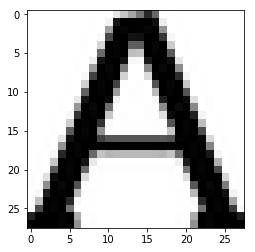

B.pickle


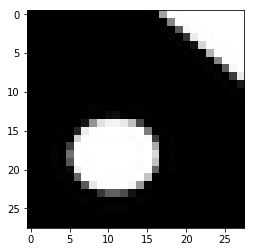

C.pickle


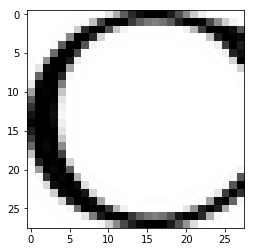

D.pickle


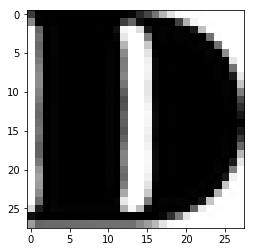

E.pickle


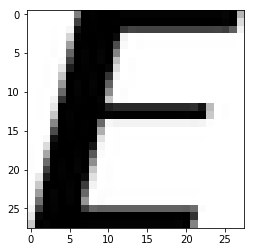

F.pickle


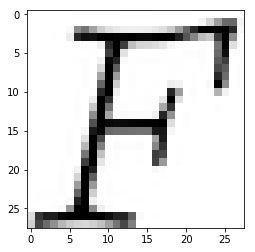

G.pickle


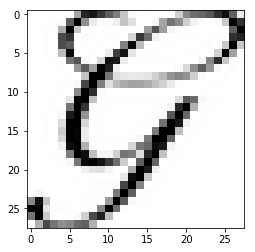

H.pickle


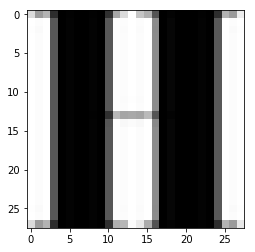

I.pickle


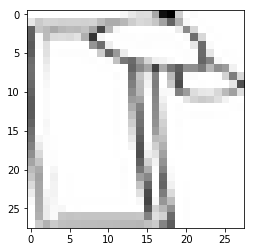

J.pickle


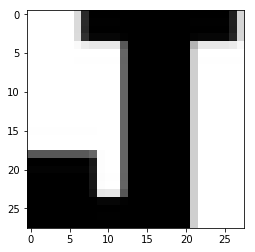

In [13]:
peak_pickled('notMNIST_large') # Have a look at notMnist_large pickled

A.pickle


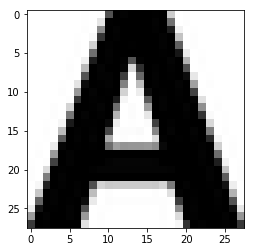

B.pickle


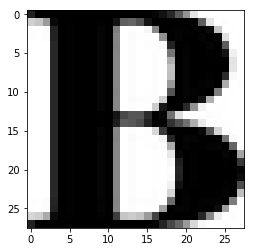

C.pickle


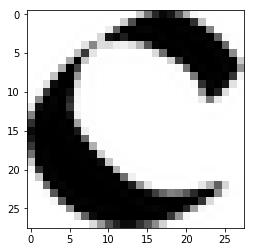

D.pickle


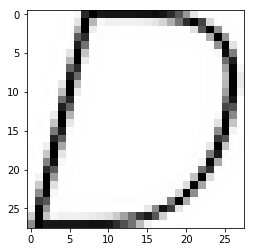

E.pickle


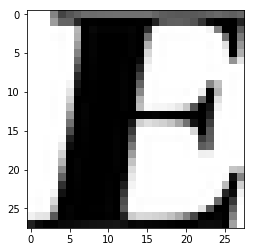

F.pickle


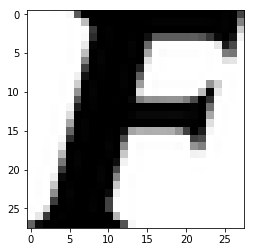

G.pickle


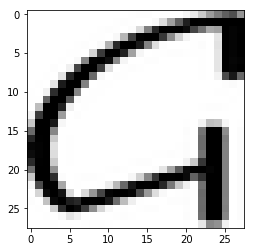

H.pickle


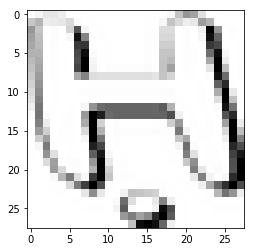

I.pickle


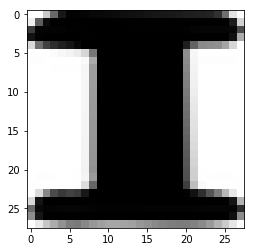

J.pickle


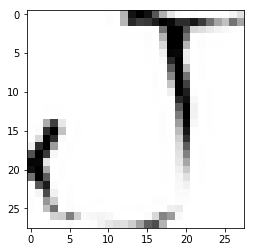

In [14]:
peak_pickled('notMNIST_small') # Have a look at notMnist_small pickled

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [15]:
letters = [chr(ord("A") + i) for i in range(0,10)] # Generate a list if the letters in data set.
print(letters)
trainpath = os.path.join(data_root,"notMNIST_large") # Path to training data.
testpath = os.path.join(data_root,"notMNIST_small") # Path to test data
for letter in letters: # For each letter
    print(letter)
    letter_train = pickle.load(open(os.path.join(trainpath,letter+".pickle"),"rb")) # Path to first letter of train.
    print("counts in Train: ", len(letter_train)) # Print count.
    letter_test = pickle.load(open(os.path.join(testpath,letter+".pickle"),"rb")) # Path to first letter of train.
    print("counts in Test: ", len(letter_test)) # Print count.
    print()
        

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
A
counts in Train:  52909
counts in Test:  1872

B
counts in Train:  52911
counts in Test:  1873

C
counts in Train:  52912
counts in Test:  1873

D
counts in Train:  52911
counts in Test:  1873

E
counts in Train:  52912
counts in Test:  1873

F
counts in Train:  52912
counts in Test:  1872

G
counts in Train:  52912
counts in Test:  1872

H
counts in Train:  52912
counts in Test:  1872

I
counts in Train:  52912
counts in Test:  1872

J
counts in Train:  52911
counts in Test:  1872



Looks balanced.

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [16]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [17]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [18]:
conversion = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}
def display_sample(dataset, labels):
    for i in range(0,len(conversion)): # For each letter.
        #print(np.shape(np.where(labels == i)[0]))
        img = np.random.choice(np.where(labels == i)[0],1) # Randomly sample one instance.
        plt.subplot(2, 5, i+1) # 2x5 subplot grid, choose ith plot.
        plt.title(conversion[labels[img][0]]) # Letter as title.
        plt.imshow(dataset[img][0], cmap='Greys',  interpolation='nearest') # Plot letter from dataset.
        

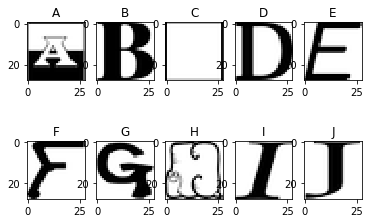

In [19]:
# Train
display_sample(train_dataset, train_labels)

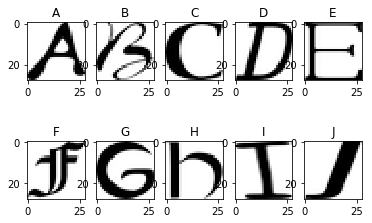

In [20]:
# Validation
display_sample(valid_dataset, valid_labels)

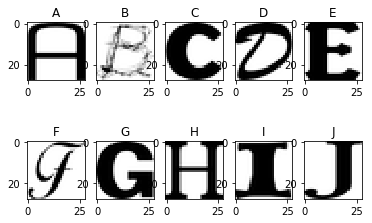

In [21]:
# Test
display_sample(test_dataset, test_labels)

Looks good.

Finally, let's save the data for later reuse:

In [22]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [23]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

To check for overlap we can hash each image and then compare the hashing between datasets. This will reveal if the same image is in two separate datasets since the hashing is unique.

In [24]:
from hashlib import sha256 # Import hashing.

def check_overlap(dataset1, dataset2):
    d1 = set([sha256(instance1.data).hexdigest() for instance1 in dataset1]) # Create hashed set of first dataset.
    d2 = set([sha256(instance2.data).hexdigest() for instance2 in dataset2]) # Create hashed set of second dataset.
    overlaps = set.intersection(d1, d2) # Calculate intersection.
    return overlaps # Return intersection and hashed sets.
    
def remove_overlap(dataset_1, dataset_2):
    overlap = check_overlap(dataset_1, dataset_2) # Get overlap.
    d1 = ([sha256(instance1.data).hexdigest() for instance1 in dataset_1]) # Hash dataset_1.
    d2 = ([sha256(instance2.data).hexdigest() for instance2 in dataset_2]) # Hash dataset_2.
    ind_dict = dict((k,i) for i,k in enumerate(d1)) # Create mapping from hash to indices.
    indices = [ind_dict[x] for x in overlap] # Find indices of intances corresponding to overlap.
    dataset_remove_new = np.delete(dataset_1, indices, axis=0) # Remove those instances.
    
    ind_dict2 = dict((k,i) for i,k in enumerate(d2))
    indices2 = [ind_dict2[x] for x in overlap]
    dataset_intact_new = np.delete(dataset_2, indices2, axis=0)
    return dataset_remove_new, dataset_intact_new # Return new datasets.

In [25]:
print("Overlaps between Train and Test ", len(check_overlap(train_dataset, test_dataset))) # Number of overlaps.
print("Overlaps between Train and Validation ", len(check_overlap(train_dataset, valid_dataset))) # Number of overlaps.
print("Overlaps between Validation and Test ", len(check_overlap(valid_dataset, test_dataset))) # Number of overlaps.

Overlaps between Train and Test  1154
Overlaps between Train and Validation  952
Overlaps between Validation and Test  60


In [26]:
new_train, new_test = (remove_overlap(train_dataset, test_dataset))
new_train, new_valid = (remove_overlap(new_train, valid_dataset))
new_test, new_valid = (remove_overlap(new_test, new_valid))
print("Overlaps between Train and Test ", len(check_overlap(new_train, new_test))) # Number of overlaps.
print("Overlaps between Test and Validation ", len(check_overlap(new_test, new_valid))) # Number of overlaps.
print("Overlaps between Train and Validation ", len(check_overlap(new_train, new_valid))) # Number of overlaps.

Overlaps between Train and Test  12
Overlaps between Test and Validation  1
Overlaps between Train and Validation  9


Dont know why we still have overlap, we should not. Could be because of non-unique hashing.

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [29]:
from sklearn.linear_model import LogisticRegression # Import logistic regression.

def result(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train) # Fit model on training data.
    return model.score(x_test, y_test) # Score model on test data.

def get_data():
    x_train = np.array([x.flatten() for x in train_dataset]) # Flatten training data.
    x_test = np.array([x.flatten() for x in test_dataset]) # Flatten test data.
    return x_train, train_labels, x_test, test_labels # Return with labels.

In [30]:
x_train, y_train, x_test, y_test = get_data() # Get data.
model = LogisticRegression() # Create Linear Regression model
for i in [50, 100, 1000, 5000, 10000, 20000]: # For each training sample size.
    random_sample = np.random.randint(0,len(x_train),i) # Create random sample
    print("Mean accuracy on test using %d training samples: %f"
          %(i, result(x_train[random_sample],y_train[random_sample],x_test, y_test, model))) # Score model.

Mean accuracy on test using 50 training samples: 0.649800
Mean accuracy on test using 100 training samples: 0.743600
Mean accuracy on test using 1000 training samples: 0.832100
Mean accuracy on test using 5000 training samples: 0.853700
Mean accuracy on test using 10000 training samples: 0.865900
Mean accuracy on test using 20000 training samples: 0.874500
